# ONNX, scikit-learn, persistence, deployment

**Xavier Dupré** - Senior Data Scientist at Microsoft - Computer Science Teacher at [ENSAE](http://www.ensae.fr/)

[ONNX](https://onnx.ai/) is a serialization format for machine learning models.


* [github/xadupre](https://github.com/xadupre)
* [github/sdpython](https://github.com/sdpython)

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=3)

In [2]:
from pyquickhelper.helpgen import NbImage

In [3]:
%matplotlib inline

## Open source tools in this talk

In [4]:
import lightgbm, onnx, skl2onnx, sklearn, torch, xgboost, onnxruntime
mods = [lightgbm, onnx, skl2onnx, onnxruntime, sklearn, torch, xgboost]
for m in mods:
    print(m.__name__, m.__version__)

lightgbm 2.2.3
onnx 1.5.0
skl2onnx 1.4.9999
onnxruntime 0.4.0
sklearn 0.22.dev0
torch 1.1.0
xgboost 0.82


## Persistence and predictions

### Persistence

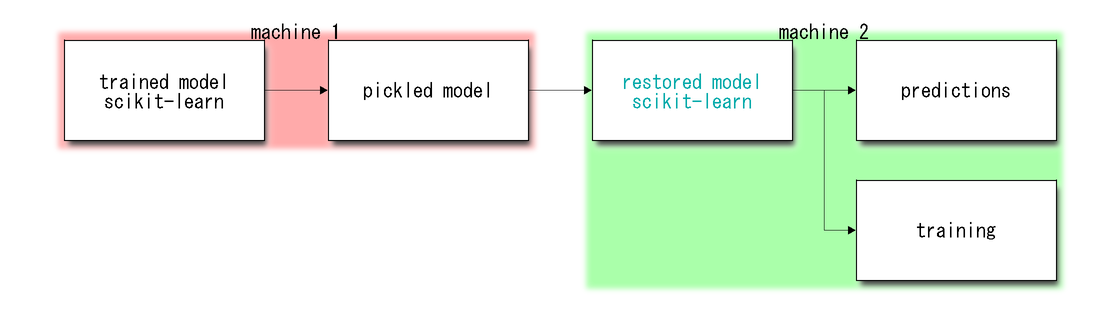

In [5]:
from pyensae.graphhelper import draw_diagram
draw_diagram("""blockdiag { default_fontsize = 20; node_width = 200; node_height = 100;
    model[label="trained model\\nscikit-learn"]; pkl[label="pickled model"];
    rest[label="restored model\\nscikit-learn", textcolor="#00AAAA"];
    pkl -> rest; pred[label="predictions"]; train[label="training"];
    group { label = "machine 1"; color = "#FFAAAA"; model -> pkl; pkl; }
    group { label = "machine 2"; color = "#AAFFAA"; rest -> pred; rest -> train; } }""")

### Main issues

* Unpickle is unstable
* Predictions are not fast (scikit-learn is optimized for batch prediction)

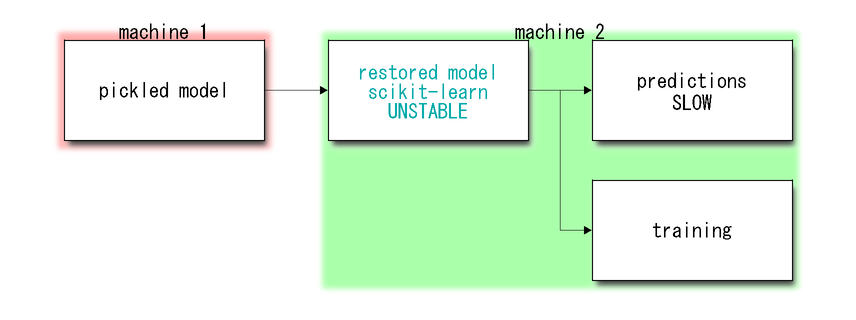

In [6]:
from pyensae.graphhelper import draw_diagram
draw_diagram("""blockdiag { default_fontsize = 20; node_width = 200; node_height = 100;
    pkl[label="pickled model"]; rest[label="restored model\\nscikit-learn\\nUNSTABLE", textcolor="#00AAAA"];
    pkl -> rest; pred[label="predictions\\nSLOW"]; train[label="training"];
    group { label = "machine 1"; color = "#FFAAAA"; pkl; } 
    group { label = "machine 2"; color = "#AAFFAA"; rest -> pred; rest -> train; } }""")

### Example with logistic regression

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\logistic.py:463: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


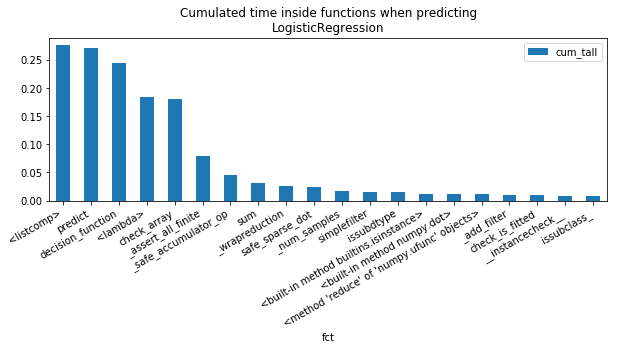

In [7]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from pyquickhelper.pycode.profiling import profile
data = load_iris()
X, y = data.data, data.target
clr = LogisticRegression().fit(X, y)
pr, df = profile(lambda: [clr.predict(X) for i in range(0, 1000)], as_df=True, rootrem=[
    r"C:\xavierdupre\__home_\github_fork\scikit-learn", r"site-packages", r"c:\Python372_x64\lib"])
ax = df[['fct', 'cum_tall']].head(n=20).set_index('fct').plot(kind='bar', figsize=(10,3), rot=30)
ax.set_title("Cumulated time inside functions when predicting\nLogisticRegression")
for la in ax.get_xticklabels(): la.set_horizontalalignment('right');

### Same with RandomForest

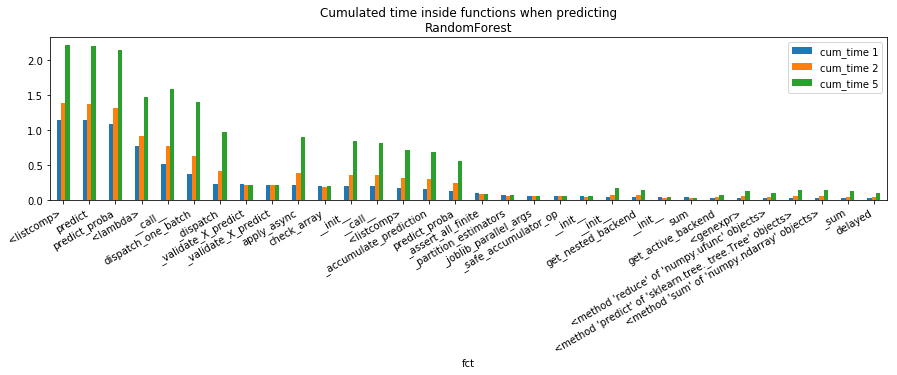

In [8]:
from sklearn.ensemble import RandomForestClassifier
sdf = None
for n in [1, 2, 5]:
    clr = RandomForestClassifier(n_estimators=n).fit(X, y)
    pr, df = profile(lambda: [clr.predict(X) for i in range(0, 1000)], as_df=True, rootrem=[
        r"C:\xavierdupre\__home_\github_fork\scikit-learn", r"site-packages", r"c:\Python372_x64\lib"])
    df = df[['fct', 'file', 'cum_tall']].head(n=35)
    df.columns = ['fct', 'file', "cum_time %d" % n]
    df = df.set_index(['fct', 'file'])
    sdf = df if sdf is None else sdf.merge(df, left_index=True, right_index=True)
sdf = sdf.sort_values("cum_time 1", ascending=False)
sdf = sdf.reset_index(drop=False).drop("file", axis=1).set_index('fct')
ax = sdf.plot(kind='bar', figsize=(15, 3), rot=30)
ax.set_title("Cumulated time inside functions when predicting\nRandomForest")
for la in ax.get_xticklabels(): la.set_horizontalalignment('right');

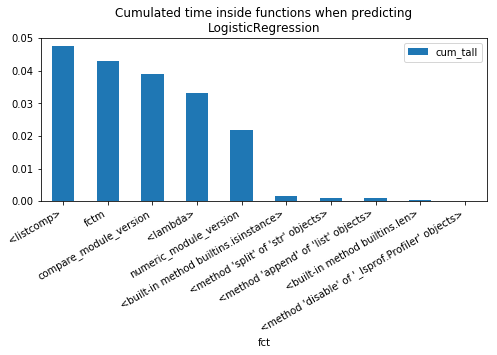

In [9]:
from pyquickhelper.pycode.profiling import profile
from pyquickhelper.texthelper import compare_module_version

def fctm():
    return compare_module_version('0.20.4', '0.22.dev0')

pr, df = profile(lambda: [fctm() for i in range(0, 1000)], as_df=True)
ax = df[['fct', 'cum_tall']].head(n=15).set_index('fct').plot(kind='bar', figsize=(8,3), rot=30)
ax.set_title("Cumulated time inside functions when predicting\nLogisticRegression")
for la in ax.get_xticklabels(): la.set_horizontalalignment('right');